In [14]:
import pandas as pd
import pymssql
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

In [15]:
def ms_sql_con():
    sql_name = 'voice_ai'
    sql_server = '10.2.4.124'
    sql_login = 'ICECORP\\1c_sql'

    with open('sql.pass','r') as file:
        sql_pass = file.read().replace('\n', '')
        file.close()

    return pymssql.connect(
            server = sql_server,
            user = sql_login,
            password = sql_pass,
            database = sql_name,
            # autocommit=True
        )

In [16]:
def read_sql():
    return pd.read_sql(query, con=ms_sql_con(), parse_dates=None)

In [17]:
def spent_time_vs_duration():
    print('spent time vs audio record duration')    
    df.plot(x="duration", y=["time"],  kind="scatter", colors = df['color'])
    plt.show()

In [18]:
def spent_time_vs_date():
    print('spent time on timeline')
    df['time_int'] = pd.to_timedelta(df.event_date).dt.total_seconds().astype(int)
    df['time_int'] = df['time_int'] - df.time_int.min()
    df.plot(x="time_int", y=["time"],  kind="scatter", colors = df['color'])
    plt.show()

In [19]:
def coef():
    x_train = np.array(df.duration).reshape(-1, 1)
    y_train = np.array(df.time).reshape(-1, 1)
    model = LinearRegression().fit(x_train, y_train)
    y_pred = model.predict(x_train)
    plt.scatter(x_train, y_train,  color='gray')
    plt.plot(x_train, y_pred, color='red', linewidth=2)
    plt.show()
    print('linear regression coef', model.coef_)
    return model.coef_[0][0]

In [20]:
def performance():
    print('performance: seconds of recognized audio per 10 min')
    counter = [0 for _ in range(int(df.time_int.max()/600))]
    
    for index, row in df.iterrows():
        cell = int(row.time_int/600)
        if len(counter) < cell + 1:
            counter.append(0)
        counter[cell] += row.duration   

    counter.insert(0,0)
    counter.pop(len(counter) - 1)
    plt.plot([x for x in range(len(counter))], counter, 'o', color='red', linewidth=2)
    plt.show()
    print([int(c) for c in counter])

In [21]:
def reco_prognose():
    query = "select sum(duration) from queue"
    df_queued = pd.read_sql(query, con=ms_sql_con())
    queued_duration = float(df_queued.iloc[0])
    time_prognose = queued_duration * performance_coef
    print('recognize time prognose:', int(time_prognose), 'sec')
    print('or', int(time_prognose/60), 'min')
    print('or', int(time_prognose/60/60), 'h')
    print('or', int(time_prognose/60/60/24), 'd')

In [22]:
def colorator(source_id):
    return 'red' if source_id == 1 else 'green'

In [23]:
def earliest_records():
    print('earliest records')
    query = "select source_id, min(record_date) from queue group by source_id order by source_id;"
    df_queued = pd.read_sql(query, con=ms_sql_con())
    print(df_queued)

In [24]:
#query = "select event_date, cpu, time, duration from perf_log where step = 1 and duration<400 and time > 1000;"
#query = "select cpu, count(cpu) as cnt, sum(time) as time_sum from perf_log where step = 2 and time > 1000 group by cpu order by cpu;"
#query = "select event_date, time as time_sum from perf_log where step = 2 and cpu = 3 order by event_date;"

In [25]:
def plot_cpu_usage():
    df.groupby(['cpu']).sum().plot(y = ['time'], kind="bar")

spent time vs audio record duration


/home/alex/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


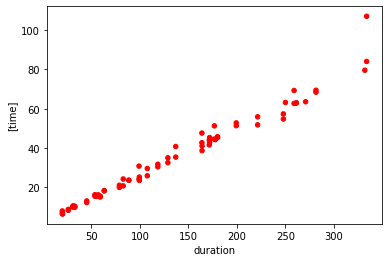

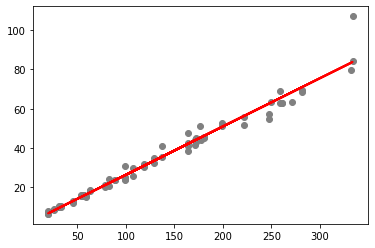

linear regression coef [[0.24566859]]
spent time on timeline


/home/alex/.local/lib/python3.7/site-packages/pandas/util/_decorators.py:208: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  return func(*args, **kwargs)
/home/alex/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


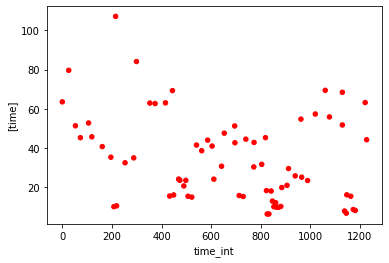

performance: seconds of recognized audio per 10 min


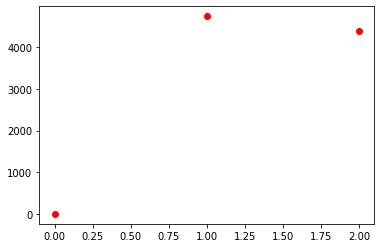

[0, 4744, 4390]
recognize time prognose: 623678 sec
or 10394 min
or 173 h
or 7 d
earliest records
   source_id                    
0          1 2021-02-25 18:48:42
1          2 2021-03-11 10:03:40


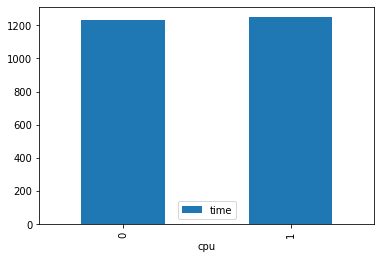

In [35]:
query = "select event_date, cpu, time, duration, source_id"
query += " from perf_log "
#query += " where cores = 9 and step = 2 and event_date > '2021-03-12 15:27:00' and time > 5;"
query += " where step = 2 and event_date > '2021-03-16 11:03:00' and time > 5;"
df = read_sql()
df['color'] = df['source_id'].apply(colorator)
spent_time_vs_duration()
performance_coef = coef()
#print('9 cores')
spent_time_vs_date()
performance()
plot_cpu_usage()
reco_prognose()
earliest_records()